In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

## Fake news counts calculation

In [ ]:
df = pd.read_csv('tweet_retweet_network.csv', dtype={'user_id':str})
df

,tweet_id,user_id_retweet_df,user_id_tweet_df,news_id,is_fake_news
0,1033706162695356417,7.873112e+08,4.335085e+07,politifact99,0.0
1,1033706162695356417,7.873112e+08,4.335085e+07,politifact340,0.0
2,1035580865160638464,3.338247e+09,1.629771e+07,politifact99,0.0
3,1035580865160638464,3.338247e+09,1.629771e+07,politifact340,0.0
4,934206237708865537,7.543102e+17,5.820642e+06,politifact99,0.0
...,...,...,...,...,...
573632,813192381583466496,NaN,3.001448e+09,politifact13600,1.0
573633,812814063763918848,NaN,5.256945e+08,politifact13600,1.0
573634,918510122363744257,NaN,1.525687e+09,politifact14621,1.0
573635,917522953390223366,NaN,7.889922e+17,politifact14621,1.0


In [ ]:
df.isna().sum()

tweet_id                   0
user_id_retweet_df    484610
user_id_tweet_df       29610
news_id                    1
is_fake_news               1
dtype: int64

In [ ]:
df = df[df['user_id_tweet_df'].notna()]
df

,tweet_id,user_id_retweet_df,user_id_tweet_df,news_id,is_fake_news
0,1033706162695356417,7.873112e+08,4.335085e+07,politifact99,0.0
1,1033706162695356417,7.873112e+08,4.335085e+07,politifact340,0.0
2,1035580865160638464,3.338247e+09,1.629771e+07,politifact99,0.0
3,1035580865160638464,3.338247e+09,1.629771e+07,politifact340,0.0
4,934206237708865537,7.543102e+17,5.820642e+06,politifact99,0.0
...,...,...,...,...,...
573632,813192381583466496,NaN,3.001448e+09,politifact13600,1.0
573633,812814063763918848,NaN,5.256945e+08,politifact13600,1.0
573634,918510122363744257,NaN,1.525687e+09,politifact14621,1.0
573635,917522953390223366,NaN,7.889922e+17,politifact14621,1.0


In [ ]:
df_followers = pd.read_csv('tweet_retweet_follower_network.csv', dtype={'user_id':str})
df_followers

,followers,user_id,is_fake_news,follow_or_retweet
0,7.873112e+08,43350851,0.0,retweet
1,3.338247e+09,16297707,0.0,retweet
2,7.543102e+17,5820642,0.0,retweet
3,2.157919e+09,1716121,0.0,retweet
4,4.867759e+09,31056977,0.0,retweet
...,...,...,...,...
4032402,3.306284e+09,3416678236,NaN,follower
4032403,4.102376e+09,3416678236,NaN,follower
4032404,4.165642e+09,3416678236,NaN,follower
4032405,3.847086e+08,3416678236,NaN,follower


In [ ]:
df_followers['is_fake_news'].unique().tolist()

[0.0, 1.0, nan]

In [ ]:
df_followers.isna().sum()

followers             267908
user_id                 2174
is_fake_news         3683264
follow_or_retweet          0
dtype: int64

In [ ]:
!pip install pyspark
!pip install graphframes
!apt-get install scala
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 66.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=0701ea0d4dd0673f3e418c9d8bc3230666f318101951433078f6d3fa7f18a9cc
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 154 kB 39.7 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libhawtjni-runtime-java libjansi-java libjansi-native-java libjline2-java
  scala-library scala-parser-combinators scala-xml
Suggested packages:
  scala-doc
The following NEW packages will be installed:
  libhawtjni-runtime-java libjansi-java libjansi-native-java libjline2-java
  scala scala-library scala-parser-combinators scala-xml
0 upgraded, 8 newly installed, 0 to remove an

In [ ]:
#import packages
import os
import sys

from pyspark import SparkConf, SparkContext
import os
import math
from pyspark.sql.functions import *
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType 
from graphframes import *

import matplotlib.pyplot as plt
%matplotlib inline

import math

In [ ]:
spark = SparkSession.builder.master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12").getOrCreate()

In [ ]:
df = spark.read.csv('tweet_retweet_network.csv', header = True)
df.show()

+-------------------+-------------------+----------------+-------------+------------+
|           tweet_id| user_id_retweet_df|user_id_tweet_df|      news_id|is_fake_news|
+-------------------+-------------------+----------------+-------------+------------+
|1033706162695356417|          787311228|        43350851| politifact99|         0.0|
|1033706162695356417|          787311228|        43350851|politifact340|         0.0|
|1035580865160638464|         3338246572|        16297707| politifact99|         0.0|
|1035580865160638464|         3338246572|        16297707|politifact340|         0.0|
| 934206237708865537| 754310205546954757|         5820642| politifact99|         0.0|
|1035367234569269248|         2157919340|         1716121| politifact99|         0.0|
|1035367234569269248|         2157919340|         1716121|politifact340|         0.0|
|1034217862313861120|         4867759271|        31056977| politifact99|         0.0|
|1034217862313861120|         4867759271|        31056

In [ ]:
tweets_df = df.select('user_id_tweet_df','news_id', 'is_fake_news')
tweets_df.show()

+----------------+-------------+------------+
|user_id_tweet_df|      news_id|is_fake_news|
+----------------+-------------+------------+
|        43350851| politifact99|         0.0|
|        43350851|politifact340|         0.0|
|        16297707| politifact99|         0.0|
|        16297707|politifact340|         0.0|
|         5820642| politifact99|         0.0|
|         1716121| politifact99|         0.0|
|         1716121|politifact340|         0.0|
|        31056977| politifact99|         0.0|
|        31056977|politifact340|         0.0|
|        13115682| politifact99|         0.0|
|        13115682|politifact340|         0.0|
|        13115682|politifact542|         0.0|
|        22696550| politifact99|         0.0|
|        22696550|politifact340|         0.0|
|       135247359| politifact99|         0.0|
|       135247359|politifact340|         0.0|
|        16312576| politifact99|         0.0|
|        16312576|politifact340|         0.0|
|        17112878| politifact99|  

In [ ]:
tweets_df_fake = tweets_df.filter('is_fake_news = 1.0')
tweets_df_fake.show()

+-------------------+---------------+------------+
|   user_id_tweet_df|        news_id|is_fake_news|
+-------------------+---------------+------------+
|               null|politifact13905|         1.0|
|           39744993|politifact14667|         1.0|
|           82770649|politifact14667|         1.0|
|           21474769|politifact14667|         1.0|
| 824797212425191425|politifact14667|         1.0|
|          110918004|politifact14667|         1.0|
|          184929716|politifact14667|         1.0|
|          110918004|politifact14667|         1.0|
|          191589342|politifact14667|         1.0|
|          110918004|politifact14667|         1.0|
|         4520399652|politifact14667|         1.0|
|          110918004|politifact14667|         1.0|
| 866690638909104129|politifact14667|         1.0|
|         2850251396|politifact14548|         1.0|
|           62088756|politifact14548|         1.0|
| 746236470684311552|politifact14548|         1.0|
|           47299616|politifact

In [ ]:
tweets_df_real = tweets_df.filter('is_fake_news = 0.0')
tweets_df_real.show()

+----------------+-------------+------------+
|user_id_tweet_df|      news_id|is_fake_news|
+----------------+-------------+------------+
|        43350851| politifact99|         0.0|
|        43350851|politifact340|         0.0|
|        16297707| politifact99|         0.0|
|        16297707|politifact340|         0.0|
|         5820642| politifact99|         0.0|
|         1716121| politifact99|         0.0|
|         1716121|politifact340|         0.0|
|        31056977| politifact99|         0.0|
|        31056977|politifact340|         0.0|
|        13115682| politifact99|         0.0|
|        13115682|politifact340|         0.0|
|        13115682|politifact542|         0.0|
|        22696550| politifact99|         0.0|
|        22696550|politifact340|         0.0|
|       135247359| politifact99|         0.0|
|       135247359|politifact340|         0.0|
|        16312576| politifact99|         0.0|
|        16312576|politifact340|         0.0|
|        17112878| politifact99|  

In [ ]:
tweets_df_fake = tweets_df_fake.na.drop()
tweets_df_fake.show()

+-------------------+---------------+------------+
|   user_id_tweet_df|        news_id|is_fake_news|
+-------------------+---------------+------------+
|           39744993|politifact14667|         1.0|
|           82770649|politifact14667|         1.0|
|           21474769|politifact14667|         1.0|
| 824797212425191425|politifact14667|         1.0|
|          110918004|politifact14667|         1.0|
|          184929716|politifact14667|         1.0|
|          110918004|politifact14667|         1.0|
|          191589342|politifact14667|         1.0|
|          110918004|politifact14667|         1.0|
|         4520399652|politifact14667|         1.0|
|          110918004|politifact14667|         1.0|
| 866690638909104129|politifact14667|         1.0|
|         2850251396|politifact14548|         1.0|
|           62088756|politifact14548|         1.0|
| 746236470684311552|politifact14548|         1.0|
|           47299616|politifact14548|         1.0|
|1004813571161755648|politifact

In [ ]:
tweets_df_real = tweets_df_real.na.drop()
tweets_df_real.show()

+----------------+-------------+------------+
|user_id_tweet_df|      news_id|is_fake_news|
+----------------+-------------+------------+
|        43350851| politifact99|         0.0|
|        43350851|politifact340|         0.0|
|        16297707| politifact99|         0.0|
|        16297707|politifact340|         0.0|
|         5820642| politifact99|         0.0|
|         1716121| politifact99|         0.0|
|         1716121|politifact340|         0.0|
|        31056977| politifact99|         0.0|
|        31056977|politifact340|         0.0|
|        13115682| politifact99|         0.0|
|        13115682|politifact340|         0.0|
|        13115682|politifact542|         0.0|
|        22696550| politifact99|         0.0|
|        22696550|politifact340|         0.0|
|       135247359| politifact99|         0.0|
|       135247359|politifact340|         0.0|
|        16312576| politifact99|         0.0|
|        16312576|politifact340|         0.0|
|        17112878| politifact99|  

In [ ]:
fake_tweets_rdd = tweets_df_fake.rdd.map(tuple)
fake_tweets_rdd.take(10)

[('39744993', 'politifact14667', '1.0'),
 ('82770649', 'politifact14667', '1.0'),
 ('21474769', 'politifact14667', '1.0'),
 ('824797212425191425', 'politifact14667', '1.0'),
 ('110918004', 'politifact14667', '1.0'),
 ('184929716', 'politifact14667', '1.0'),
 ('110918004', 'politifact14667', '1.0'),
 ('191589342', 'politifact14667', '1.0'),
 ('110918004', 'politifact14667', '1.0'),
 ('4520399652', 'politifact14667', '1.0')]

In [ ]:
fake_tweets_rdd.take(1)[0][2]

'1.0'

In [ ]:
fake_tweets_map = fake_tweets_rdd.map(lambda x: (x[0], 1))
fake_tweets_map.take(10)

[('39744993', 1),
 ('82770649', 1),
 ('21474769', 1),
 ('824797212425191425', 1),
 ('110918004', 1),
 ('184929716', 1),
 ('110918004', 1),
 ('191589342', 1),
 ('110918004', 1),
 ('4520399652', 1)]

In [ ]:
fake_tweets_count = fake_tweets_map.reduceByKey(lambda n1,n2: n1+n2)
fake_tweets_count.take(10)

[('21474769', 4),
 ('824797212425191425', 1),
 ('110918004', 25),
 ('191589342', 1),
 ('62088756', 1),
 ('3097431114', 6),
 ('2862646276', 1),
 ('835117966165364736', 3),
 ('2905658255', 2),
 ('935085971451924480', 2)]

In [ ]:
real_tweets_rdd = tweets_df_real.rdd.map(tuple)
real_tweets_rdd.take(10)

[('43350851', 'politifact99', '0.0'),
 ('43350851', 'politifact340', '0.0'),
 ('16297707', 'politifact99', '0.0'),
 ('16297707', 'politifact340', '0.0'),
 ('5820642', 'politifact99', '0.0'),
 ('1716121', 'politifact99', '0.0'),
 ('1716121', 'politifact340', '0.0'),
 ('31056977', 'politifact99', '0.0'),
 ('31056977', 'politifact340', '0.0'),
 ('13115682', 'politifact99', '0.0')]

In [ ]:
real_tweets_map = real_tweets_rdd.map(lambda x: (x[0], 1))
real_tweets_map.take(10)

[('43350851', 1),
 ('43350851', 1),
 ('16297707', 1),
 ('16297707', 1),
 ('5820642', 1),
 ('1716121', 1),
 ('1716121', 1),
 ('31056977', 1),
 ('31056977', 1),
 ('13115682', 1)]

In [ ]:
real_tweets_count = real_tweets_map.reduceByKey(lambda n1,n2: n1+n2)
real_tweets_count.take(10)

[('1716121', 7),
 ('13115682', 20),
 ('135247359', 4),
 ('17112878', 426),
 ('993451813', 1),
 ('50174697', 2),
 ('17921386', 2),
 ('18812572', 11),
 ('2463977196', 1),
 ('994358258646355968', 2)]

In [ ]:
all_tweets_count = real_tweets_count.fullOuterJoin(fake_tweets_count)
all_tweets_count = all_tweets_count.map(lambda x: (x[0], x[1][0], x[1][1]))
all_tweets_count.take(10)

[('1716121', 7, None),
 ('13115682', 20, 1),
 ('135247359', 4, 2),
 ('17112878', 426, None),
 ('993451813', 1, 3),
 ('50174697', 2, 1),
 ('17921386', 2, None),
 ('18812572', 11, None),
 ('2463977196', 1, None),
 ('994358258646355968', 2, None)]

In [ ]:
rdd_columns = ['user_id', 'tweet_real_news_count', 'tweet_fake_news_count']
tweet_count_df = spark.createDataFrame(all_tweets_count, schema = rdd_columns)
tweet_count_df = tweet_count_df.na.fill(0)
tweet_count_df.show(10)

+------------------+---------------------+---------------------+
|           user_id|tweet_real_news_count|tweet_fake_news_count|
+------------------+---------------------+---------------------+
|           1716121|                    7|                    0|
|          13115682|                   20|                    1|
|         135247359|                    4|                    2|
|          17112878|                  426|                    0|
|         993451813|                    1|                    3|
|          50174697|                    2|                    1|
|          17921386|                    2|                    0|
|          18812572|                   11|                    0|
|        2463977196|                    1|                    0|
|994358258646355968|                    2|                    0|
+------------------+---------------------+---------------------+
only showing top 10 rows



In [ ]:
retweets_df = df.select('user_id_retweet_df','news_id', 'is_fake_news')
retweets_df.show()

+-------------------+-------------+------------+
| user_id_retweet_df|      news_id|is_fake_news|
+-------------------+-------------+------------+
|          787311228| politifact99|         0.0|
|          787311228|politifact340|         0.0|
|         3338246572| politifact99|         0.0|
|         3338246572|politifact340|         0.0|
| 754310205546954757| politifact99|         0.0|
|         2157919340| politifact99|         0.0|
|         2157919340|politifact340|         0.0|
|         4867759271| politifact99|         0.0|
|         4867759271|politifact340|         0.0|
|          370794560| politifact99|         0.0|
|          370794560|politifact340|         0.0|
|          370794560|politifact542|         0.0|
|1034479942895951873| politifact99|         0.0|
|1034479942895951873|politifact340|         0.0|
|          254708177| politifact99|         0.0|
|          254708177|politifact340|         0.0|
|           27128191| politifact99|         0.0|
|           27128191

In [ ]:
retweets_df = retweets_df.na.drop()
retweets_df.show()

+-------------------+-------------+------------+
| user_id_retweet_df|      news_id|is_fake_news|
+-------------------+-------------+------------+
|          787311228| politifact99|         0.0|
|          787311228|politifact340|         0.0|
|         3338246572| politifact99|         0.0|
|         3338246572|politifact340|         0.0|
| 754310205546954757| politifact99|         0.0|
|         2157919340| politifact99|         0.0|
|         2157919340|politifact340|         0.0|
|         4867759271| politifact99|         0.0|
|         4867759271|politifact340|         0.0|
|          370794560| politifact99|         0.0|
|          370794560|politifact340|         0.0|
|          370794560|politifact542|         0.0|
|1034479942895951873| politifact99|         0.0|
|1034479942895951873|politifact340|         0.0|
|          254708177| politifact99|         0.0|
|          254708177|politifact340|         0.0|
|           27128191| politifact99|         0.0|
|           27128191

In [ ]:
retweets_df_fake = retweets_df.filter('is_fake_news = 1.0')
retweets_df_fake.show()

+-------------------+---------------+------------+
| user_id_retweet_df|        news_id|is_fake_news|
+-------------------+---------------+------------+
|         3162969997|politifact13905|         1.0|
| 885692002591006720|politifact14667|         1.0|
|         1917218150|politifact14667|         1.0|
|          255928301|politifact14667|         1.0|
| 822271632383295493|politifact14667|         1.0|
|           17597022|politifact14667|         1.0|
|           22824243|politifact14667|         1.0|
|         1378552322|politifact14667|         1.0|
|          188343111|politifact14667|         1.0|
|1017951685224759296|politifact14667|         1.0|
|            9924742|politifact14667|         1.0|
|          915331472|politifact14667|         1.0|
| 960571982780731392|politifact14667|         1.0|
|         2716850508|politifact14548|         1.0|
| 948025288356642816|politifact14548|         1.0|
| 759421234375331840|politifact14548|         1.0|
|          103253996|politifact

In [ ]:
retweets_df_real = retweets_df.filter('is_fake_news = 0.0')
retweets_df_real.show()

+-------------------+-------------+------------+
| user_id_retweet_df|      news_id|is_fake_news|
+-------------------+-------------+------------+
|          787311228| politifact99|         0.0|
|          787311228|politifact340|         0.0|
|         3338246572| politifact99|         0.0|
|         3338246572|politifact340|         0.0|
| 754310205546954757| politifact99|         0.0|
|         2157919340| politifact99|         0.0|
|         2157919340|politifact340|         0.0|
|         4867759271| politifact99|         0.0|
|         4867759271|politifact340|         0.0|
|          370794560| politifact99|         0.0|
|          370794560|politifact340|         0.0|
|          370794560|politifact542|         0.0|
|1034479942895951873| politifact99|         0.0|
|1034479942895951873|politifact340|         0.0|
|          254708177| politifact99|         0.0|
|          254708177|politifact340|         0.0|
|           27128191| politifact99|         0.0|
|           27128191

In [ ]:
fake_retweets_rdd = retweets_df_fake.rdd.map(tuple)
fake_retweets_rdd.take(10)

[('3162969997', 'politifact13905', '1.0'),
 ('885692002591006720', 'politifact14667', '1.0'),
 ('1917218150', 'politifact14667', '1.0'),
 ('255928301', 'politifact14667', '1.0'),
 ('822271632383295493', 'politifact14667', '1.0'),
 ('17597022', 'politifact14667', '1.0'),
 ('22824243', 'politifact14667', '1.0'),
 ('1378552322', 'politifact14667', '1.0'),
 ('188343111', 'politifact14667', '1.0'),
 ('1017951685224759296', 'politifact14667', '1.0')]

In [ ]:
real_retweets_rdd = retweets_df_real.rdd.map(tuple)
real_retweets_rdd.take(10)

[('787311228', 'politifact99', '0.0'),
 ('787311228', 'politifact340', '0.0'),
 ('3338246572', 'politifact99', '0.0'),
 ('3338246572', 'politifact340', '0.0'),
 ('754310205546954757', 'politifact99', '0.0'),
 ('2157919340', 'politifact99', '0.0'),
 ('2157919340', 'politifact340', '0.0'),
 ('4867759271', 'politifact99', '0.0'),
 ('4867759271', 'politifact340', '0.0'),
 ('370794560', 'politifact99', '0.0')]

In [ ]:
fake_retweets_map = fake_retweets_rdd.map(lambda x: (x[0], 1))
fake_retweets_map.take(10)

[('3162969997', 1),
 ('885692002591006720', 1),
 ('1917218150', 1),
 ('255928301', 1),
 ('822271632383295493', 1),
 ('17597022', 1),
 ('22824243', 1),
 ('1378552322', 1),
 ('188343111', 1),
 ('1017951685224759296', 1)]

In [ ]:
real_retweets_map = real_retweets_rdd.map(lambda x: (x[0], 1))
real_retweets_map.take(10)

[('787311228', 1),
 ('787311228', 1),
 ('3338246572', 1),
 ('3338246572', 1),
 ('754310205546954757', 1),
 ('2157919340', 1),
 ('2157919340', 1),
 ('4867759271', 1),
 ('4867759271', 1),
 ('370794560', 1)]

In [ ]:
fake_retweets_count = fake_retweets_map.reduceByKey(lambda n1,n2: n1+n2)
fake_retweets_count.take(10)

[('3162969997', 1),
 ('1917218150', 1),
 ('255928301', 1),
 ('822271632383295493', 1),
 ('17597022', 1),
 ('22824243', 1),
 ('1378552322', 1),
 ('1017951685224759296', 2),
 ('9924742', 1),
 ('960571982780731392', 1)]

In [ ]:
real_retweets_count = real_retweets_map.reduceByKey(lambda n1,n2: n1+n2)
real_retweets_count.take(10)

[('3338246572', 2),
 ('2157919340', 2),
 ('4867759271', 2),
 ('370794560', 3),
 ('1325337348', 2),
 ('1924285831', 1),
 ('2548750220', 1),
 ('3107597132', 1),
 ('18907297', 1),
 ('479832877', 2)]

In [ ]:
all_retweets_count = real_retweets_count.fullOuterJoin(fake_retweets_count)
all_retweets_count = all_retweets_count.map(lambda x: (x[0], x[1][0], x[1][1]))
all_retweets_count.take(10)

[('3338246572', 2, None),
 ('2157919340', 2, 1),
 ('4867759271', 2, None),
 ('370794560', 3, None),
 ('1325337348', 2, 2),
 ('1924285831', 1, None),
 ('2548750220', 1, None),
 ('3107597132', 1, 1),
 ('18907297', 1, None),
 ('479832877', 2, None)]

In [ ]:
rdd_columns_2 = ['user_id', 'retweet_real_news_count', 'retweet_fake_news_count']
retweet_count_df = spark.createDataFrame(all_retweets_count, schema = rdd_columns_2)
retweet_count_df = retweet_count_df.na.fill(0)
retweet_count_df.show(10)

+----------+-----------------------+-----------------------+
|   user_id|retweet_real_news_count|retweet_fake_news_count|
+----------+-----------------------+-----------------------+
|3338246572|                      2|                      0|
|2157919340|                      2|                      1|
|4867759271|                      2|                      0|
| 370794560|                      3|                      0|
|1325337348|                      2|                      2|
|1924285831|                      1|                      0|
|2548750220|                      1|                      0|
|3107597132|                      1|                      1|
|  18907297|                      1|                      0|
| 479832877|                      2|                      0|
+----------+-----------------------+-----------------------+
only showing top 10 rows



In [ ]:
tweet_count_df = tweet_count_df.withColumn("tweet_count", tweet_count_df["tweet_real_news_count"] + tweet_count_df["tweet_fake_news_count"])
tweet_count_df.show(10)

+------------------+---------------------+---------------------+-----------+
|           user_id|tweet_real_news_count|tweet_fake_news_count|tweet_count|
+------------------+---------------------+---------------------+-----------+
|           1716121|                    7|                    0|          7|
|          13115682|                   20|                    1|         21|
|         135247359|                    4|                    2|          6|
|          17112878|                  426|                    0|        426|
|         993451813|                    1|                    3|          4|
|          50174697|                    2|                    1|          3|
|          17921386|                    2|                    0|          2|
|          18812572|                   11|                    0|         11|
|        2463977196|                    1|                    0|          1|
|994358258646355968|                    2|                    0|          2|

In [ ]:
retweet_count_df = retweet_count_df.withColumn("retweet_count", retweet_count_df["retweet_real_news_count"] + retweet_count_df["retweet_fake_news_count"])
retweet_count_df.show(10)

+----------+-----------------------+-----------------------+-------------+
|   user_id|retweet_real_news_count|retweet_fake_news_count|retweet_count|
+----------+-----------------------+-----------------------+-------------+
|3338246572|                      2|                      0|            2|
|2157919340|                      2|                      1|            3|
|4867759271|                      2|                      0|            2|
| 370794560|                      3|                      0|            3|
|1325337348|                      2|                      2|            4|
|1924285831|                      1|                      0|            1|
|2548750220|                      1|                      0|            1|
|3107597132|                      1|                      1|            2|
|  18907297|                      1|                      0|            1|
| 479832877|                      2|                      0|            2|
+----------+-------------

In [ ]:
tweet_retweet_counts_df = tweet_count_df.join(retweet_count_df,'user_id',"outer")
tweet_retweet_counts_df = tweet_retweet_counts_df.na.fill(0)
tweet_retweet_counts_df.show(10)

+-------------------+---------------------+---------------------+-----------+-----------------------+-----------------------+-------------+
|            user_id|tweet_real_news_count|tweet_fake_news_count|tweet_count|retweet_real_news_count|retweet_fake_news_count|retweet_count|
+-------------------+---------------------+---------------------+-----------+-----------------------+-----------------------+-------------+
|1000011520099737600|                    1|                    0|          1|                      0|                      0|            0|
|1000015310651645953|                    1|                    0|          1|                      0|                      0|            0|
|1000016148920913920|                    1|                    0|          1|                      0|                      0|            0|
|1000017210381819904|                    1|                    0|          1|                      0|                      0|            0|
|          100002112

In [ ]:
tweet_retweet_counts_df = tweet_retweet_counts_df.withColumn("tweet_retweet_fake_count", tweet_retweet_counts_df["tweet_fake_news_count"] + tweet_retweet_counts_df["retweet_fake_news_count"])
tweet_retweet_counts_df = tweet_retweet_counts_df.withColumn("tweet_retweet_real_count", tweet_retweet_counts_df["tweet_real_news_count"] + tweet_retweet_counts_df["retweet_real_news_count"])
tweet_retweet_counts_df = tweet_retweet_counts_df.withColumn("tweet_retweet_count", tweet_retweet_counts_df["retweet_count"] + tweet_retweet_counts_df["tweet_count"])
tweet_retweet_counts_df.show(10)

+-------------------+---------------------+---------------------+-----------+-----------------------+-----------------------+-------------+------------------------+------------------------+-------------------+
|            user_id|tweet_real_news_count|tweet_fake_news_count|tweet_count|retweet_real_news_count|retweet_fake_news_count|retweet_count|tweet_retweet_fake_count|tweet_retweet_real_count|tweet_retweet_count|
+-------------------+---------------------+---------------------+-----------+-----------------------+-----------------------+-------------+------------------------+------------------------+-------------------+
|1000011520099737600|                    1|                    0|          1|                      0|                      0|            0|                       0|                       1|                  1|
|1000015310651645953|                    1|                    0|          1|                      0|                      0|            0|                     

In [ ]:
tweet_retweet_counts_df = tweet_retweet_counts_df.withColumn("percentage_fake", tweet_retweet_counts_df["tweet_retweet_fake_count"] / tweet_retweet_counts_df["tweet_retweet_count"])
tweet_retweet_counts_df.show(10)

+-------------------+---------------------+---------------------+-----------+-----------------------+-----------------------+-------------+------------------------+------------------------+-------------------+------------------+
|            user_id|tweet_real_news_count|tweet_fake_news_count|tweet_count|retweet_real_news_count|retweet_fake_news_count|retweet_count|tweet_retweet_fake_count|tweet_retweet_real_count|tweet_retweet_count|   percentage_fake|
+-------------------+---------------------+---------------------+-----------+-----------------------+-----------------------+-------------+------------------------+------------------------+-------------------+------------------+
|1000011520099737600|                    1|                    0|          1|                      0|                      0|            0|                       0|                       1|                  1|               0.0|
|1000015310651645953|                    1|                    0|          1|       

In [ ]:
#tweet_retweet_counts_df.toPandas().to_csv('tweet_retweet_counts.csv', index = False)

In [ ]:
df_test = pd.read_csv('tweet_retweet_counts.csv')
df_test

,user_id,tweet_real_news_count,tweet_fake_news_count,tweet_count,retweet_real_news_count,retweet_fake_news_count,retweet_count,tweet_retweet_fake_count,tweet_retweet_real_count,tweet_retweet_count,percentage_fake
0,1000011520099737600,1,0,1,0,0,0,0,1,1,0.0
1,1000015310651645953,1,0,1,0,0,0,0,1,1,0.0
2,1000016148920913920,1,0,1,0,0,0,0,1,1,0.0
3,1000017210381819904,1,0,1,0,0,0,0,1,1,0.0
4,100002112,2,0,2,0,0,0,0,2,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
364759,999970415748435969,4,0,4,0,0,0,0,4,4,0.0
364760,999973035540209664,8,0,8,0,0,0,0,8,8,0.0
364761,999973630195961856,1,0,1,0,0,0,0,1,1,0.0
364762,999975256981942273,0,1,1,0,0,0,1,0,1,1.0


# EDA Tweet_retweet network

In [149]:
df = pd.read_csv('tweet_retweet_counts.csv')
df

,user_id,tweet_real_news_count,tweet_fake_news_count,tweet_count,retweet_real_news_count,retweet_fake_news_count,retweet_count,tweet_retweet_fake_count,tweet_retweet_real_count,tweet_retweet_count,percentage_fake
0,1000011520099737600,1,0,1,0,0,0,0,1,1,0.0
1,1000015310651645953,1,0,1,0,0,0,0,1,1,0.0
2,1000016148920913920,1,0,1,0,0,0,0,1,1,0.0
3,1000017210381819904,1,0,1,0,0,0,0,1,1,0.0
4,100002112,2,0,2,0,0,0,0,2,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
364759,999970415748435969,4,0,4,0,0,0,0,4,4,0.0
364760,999973035540209664,8,0,8,0,0,0,0,8,8,0.0
364761,999973630195961856,1,0,1,0,0,0,0,1,1,0.0
364762,999975256981942273,0,1,1,0,0,0,1,0,1,1.0


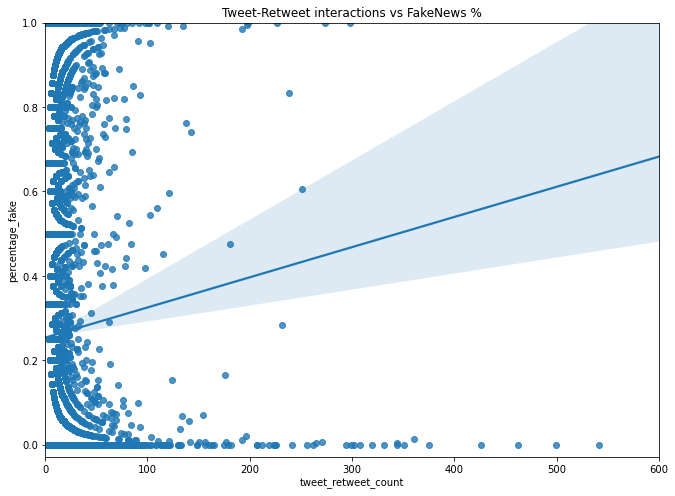

In [170]:
plt.figure(figsize=(11,8))
# sns.regplot()

sns.regplot(data=df, y='percentage_fake', x='tweet_retweet_count')
plt.ylim(-.03,1)
plt.title('Tweet-Retweet interactions vs FakeNews %')
plt.xlim(0,600)

plt.show()

In [144]:
# df_ff = pd.read_csv('data_summary/tweet_retweet_follower_network.csv', dtype={'user_id':str})
# fake_cnt = df_ff[['user_id','is_fake_news']].groupby('user_id').sum()
# fake_cnt = fake_cnt.reset_index()
# fake_cnt = fake_cnt.drop_duplicates(subset='user_id')
# df_ff = df_ff.drop(columns=['is_fake_news']).merge(fake_cnt,  left_on='user_id', right_on='user_id')
# df_ff['is_fake_news'] = df_ff['is_fake_news'].astype(int)
# df_ff


,followers,user_id,follow_or_retweet,is_fake_news
0,7.873112e+08,43350851,retweet,0
1,1.149386e+08,43350851,retweet,0
2,9.609944e+17,43350851,retweet,0
3,9.924177e+17,43350851,retweet,0
4,9.300641e+08,43350851,retweet,0
...,...,...,...,...
4030228,3.306284e+09,3416678236,follower,0
4030229,4.102376e+09,3416678236,follower,0
4030230,4.165642e+09,3416678236,follower,0
4030231,3.847086e+08,3416678236,follower,0


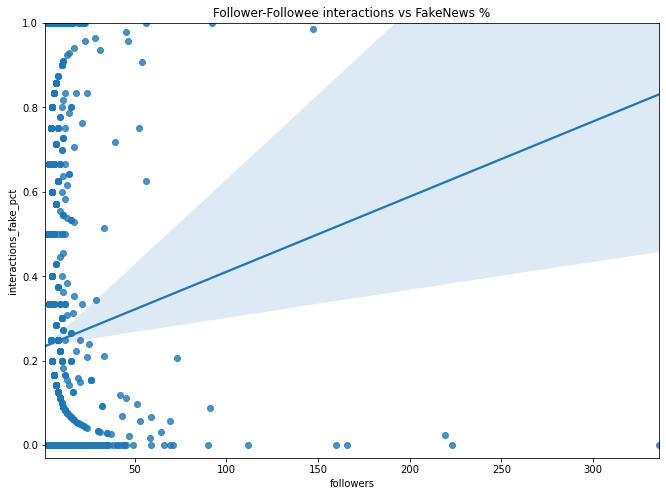

In [228]:
df_ff = pd.read_csv('data_summary/tweet_retweet_follower_network.csv').dropna()
# df_ff = df_ff[df_ff['is_fake_news']==1]
df_ff = df_ff.groupby('user_id').agg({'followers':'count','follow_or_retweet':'count', 'is_fake_news':'sum'})
df_ff['interactions_fake_pct'] = df_ff['is_fake_news']/df_ff['follow_or_retweet']
        
        
plt.figure(figsize=(11,8))
sns.regplot(x="followers", y="interactions_fake_pct", data=df_ff)
plt.ylim(-.03,1)
plt.title('Follower-Followee interactions vs FakeNews %')

plt.show()

In [181]:
tweet_df = pd.concat([pd.read_csv('data_summary/news_tweet_real.csv', index_col=0, dtype={'user_id':str}), pd.read_csv('data_summary/news_tweet_fake.csv', index_col=0, dtype={'user_id':str})])

C:\Users\f2110\AppData\Local\Temp\ipykernel_36012\3861400377.py:1: DtypeWarning: Columns (79,84,90,95,111,112,113,114,115,116,117,118,119) have mixed types. Specify dtype option on import or set low_memory=False.
  tweet_df = pd.concat([pd.read_csv('data_summary/news_tweet_real.csv', index_col=0, dtype={'user_id':str}), pd.read_csv('data_summary/news_tweet_fake.csv', index_col=0, dtype={'user_id':str})])
C:\Users\f2110\AppData\Local\Temp\ipykernel_36012\3861400377.py:1: DtypeWarning: Columns (99,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  tweet_df = pd.concat([pd.read_csv('data_summary/news_tweet_real.csv', index_col=0, dtype={'user_id':str}), pd.read_csv('data_summary/news_tweet_fake.csv', index_col=0, dtype={'user_id':str})])


(1119893, 5)


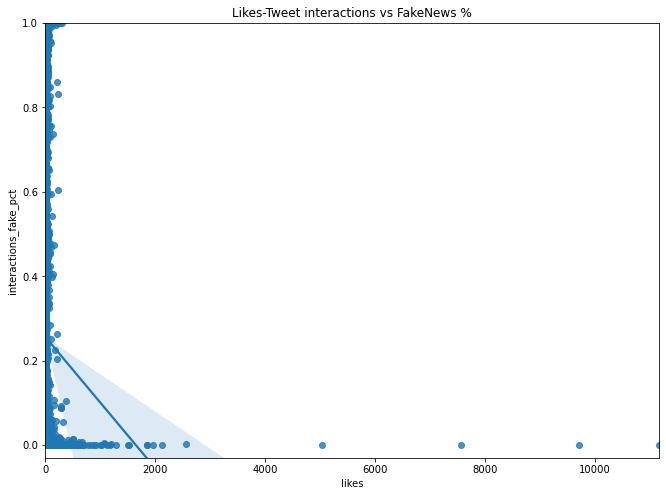

In [234]:
# Merge

df_likes_fake = pd.read_csv('data_summary/news_likes_fake.csv', dtype={'likes':str}, index_col=0)
df_likes_fake['likes']  = df_likes_fake.index
df_likes = pd.concat([pd.read_csv('data_summary/news_likes_real.csv', dtype={'likes':str}, index_col=0), df_likes_fake])

df_likes_network = df_likes.merge(tweet_df[['tweet_id','user_id','is_fake_news', 'news_id']], left_on='tweet_id', right_on='tweet_id', how='outer', suffixes=['_likes_df', '_tweet_df'])

df_likes_network['news_id'] = df_likes_network['news_id_tweet_df']
df_likes_network['is_fake_news'] = df_likes_network['is_fake_news_tweet_df']

df_likes_network.drop(columns=['news_id_likes_df','is_fake_news_likes_df','news_id_tweet_df','is_fake_news_tweet_df'], inplace=True)
print(df_likes_network.shape)
df_likes_network.head()

df_likes = df_likes_network.groupby('user_id').agg({'likes':'count','tweet_id':'count', 'is_fake_news':'sum'})
df_likes['interactions_fake_pct'] = df_likes['is_fake_news']/df_likes['tweet_id']
        
# # slope, intercept, r_value, pv, se = stats.linregress(df_like['followers'],df_like['interactions_fake_pct'])

plt.figure(figsize=(11,8))
sns.regplot(x="likes", y="interactions_fake_pct", data=df_likes)
plt.ylim(-0.03,1)
plt.title('Likes-Tweet interactions vs FakeNews %')

plt.show()

### Correlations

In [223]:
df[['tweet_retweet_count','tweet_retweet_fake_count']].corr()

,tweet_retweet_count,tweet_retweet_fake_count
tweet_retweet_count,1.000000,0.344434
tweet_retweet_fake_count,0.344434,1.000000


In [229]:
df_ff[['followers','is_fake_news']].corr()

,followers,is_fake_news
followers,1.0000,0.3752
is_fake_news,0.3752,1.0000


In [232]:
df_likes[['likes','interactions_fake_pct']].corr()

,likes,interactions_fake_pct
likes,1.000000,-0.012845
interactions_fake_pct,-0.012845,1.000000


## Tweet retweet communities

In [3]:
df_com1 = pd.read_csv('le_community_degrees/le_com1_degrees.csv')
df_com2 = pd.read_csv('le_community_degrees/le_com2_degrees.csv')
df_com3 = pd.read_csv('le_community_degrees/le_com3_degrees.csv')
df_com4 = pd.read_csv('le_community_degrees/le_com4_degrees.csv')
df_com5 = pd.read_csv('le_community_degrees/le_com5_degrees.csv')
df_com1

,Unnamed: 0,id,degree
0,0,1.911303e+09,146
1,1,1.997682e+08,15
2,2,7.148876e+17,13
3,3,5.329788e+07,12
4,4,2.999356e+07,11
...,...,...,...
381,381,4.014770e+08,1
382,382,6.038136e+07,1
383,383,1.098960e+08,1
384,384,5.488242e+07,1


In [4]:
df_com1.drop('Unnamed: 0', axis = 1, inplace = True)
df_com2.drop('Unnamed: 0', axis = 1, inplace = True)
df_com3.drop('Unnamed: 0', axis = 1, inplace = True)
df_com4.drop('Unnamed: 0', axis = 1, inplace = True)
df_com5.drop('Unnamed: 0', axis = 1, inplace = True)
df_com1

,id,degree
0,1.911303e+09,146
1,1.997682e+08,15
2,7.148876e+17,13
3,5.329788e+07,12
4,2.999356e+07,11
...,...,...
381,4.014770e+08,1
382,6.038136e+07,1
383,1.098960e+08,1
384,5.488242e+07,1


In [5]:
com1_metrics = pd.merge(df,df_com1, left_on = "user_id", right_on = 'id').sort_values('degree', ascending = False)
com1_metrics

,user_id,tweet_real_news_count,tweet_fake_news_count,tweet_count,retweet_real_news_count,retweet_fake_news_count,retweet_count,tweet_retweet_fake_count,tweet_retweet_real_count,tweet_retweet_count,percentage_fake,id,degree
39,1911303422,3,189,192,0,0,0,189,3,192,0.984375,1.911303e+09,146
43,199768203,3,12,15,0,9,9,21,3,24,0.875000,1.997682e+08,15
156,714887575081607168,0,37,37,0,0,0,37,0,37,1.000000,7.148876e+17,13
132,53297881,2,13,15,0,0,0,13,2,15,0.866667,5.329788e+07,12
77,29993565,0,15,15,0,0,0,15,0,15,1.000000,2.999356e+07,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,26107813,0,0,0,0,1,1,1,0,1,1.000000,2.610781e+07,1
195,1420535665,0,0,0,1,1,2,1,1,2,0.500000,1.420536e+09,1
196,143959357,0,1,1,0,0,0,1,0,1,1.000000,1.439594e+08,1
197,1440616824,0,6,6,0,1,1,7,0,7,1.000000,1.440617e+09,1


In [6]:
com2_metrics = pd.merge(df,df_com2, left_on = "user_id", right_on = 'id').sort_values('degree', ascending = False)
com2_metrics

,user_id,tweet_real_news_count,tweet_fake_news_count,tweet_count,retweet_real_news_count,retweet_fake_news_count,retweet_count,tweet_retweet_fake_count,tweet_retweet_real_count,tweet_retweet_count,percentage_fake,id,degree
60,3772895061,15,42,57,0,0,0,42,15,57,0.736842,3.772895e+09,28
158,24544802,3,24,27,0,0,0,24,3,27,0.888889,2.454480e+07,23
224,790019230389248000,166,66,232,0,0,0,66,166,232,0.284483,7.900192e+17,14
84,550955977,0,36,36,0,0,0,36,0,36,1.000000,5.509560e+08,14
67,42685467,0,49,49,0,0,0,49,0,49,1.000000,4.268547e+07,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,889040726,0,0,0,0,1,1,1,0,1,1.000000,8.890407e+08,1
112,896187666,0,0,0,0,1,1,1,0,1,1.000000,8.961877e+08,1
113,904321107112722432,0,0,0,0,1,1,1,0,1,1.000000,9.043211e+17,1
114,950830002,0,1,1,0,0,0,1,0,1,1.000000,9.508300e+08,1


In [7]:
com3_metrics = pd.merge(df,df_com3, left_on = "user_id", right_on = 'id').sort_values('degree', ascending = False)
com3_metrics

,user_id,tweet_real_news_count,tweet_fake_news_count,tweet_count,retweet_real_news_count,retweet_fake_news_count,retweet_count,tweet_retweet_fake_count,tweet_retweet_real_count,tweet_retweet_count,percentage_fake,id,degree
64,52572719,2,65,67,0,0,0,65,2,67,0.970149,5.257272e+07,31
79,753776864682999808,0,19,19,0,0,0,19,0,19,1.000000,7.537769e+17,18
132,38863786,0,32,32,0,0,0,32,0,32,1.000000,3.886379e+07,11
39,317223956,1,13,14,1,0,1,13,2,15,0.866667,3.172240e+08,10
168,829735580,6,11,17,0,0,0,11,6,17,0.647059,8.297356e+08,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,4886325111,0,0,0,0,1,1,1,0,1,1.000000,4.886325e+09,1
58,474999990,0,1,1,0,1,1,2,0,2,1.000000,4.750000e+08,1
57,4659654224,0,0,0,0,1,1,1,0,1,1.000000,4.659654e+09,1
56,4627221853,0,0,0,0,1,1,1,0,1,1.000000,4.627222e+09,1


In [8]:
com4_metrics = pd.merge(df,df_com4, left_on = "user_id", right_on = 'id').sort_values('degree', ascending = False)
com4_metrics

,user_id,tweet_real_news_count,tweet_fake_news_count,tweet_count,retweet_real_news_count,retweet_fake_news_count,retweet_count,tweet_retweet_fake_count,tweet_retweet_real_count,tweet_retweet_count,percentage_fake,id,degree
126,3291556676,0,23,23,0,0,0,23,0,23,1.000000,3.291557e+09,19
115,2406059855,1,66,67,0,0,0,66,1,67,0.985075,2.406060e+09,12
98,125128428,0,14,14,0,0,0,14,0,14,1.000000,1.251284e+08,10
63,634330366,0,11,11,0,0,0,11,0,11,1.000000,6.343304e+08,10
40,3481965513,3,13,16,0,0,0,13,3,16,0.812500,3.481966e+09,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,892130999454257152,0,0,0,0,1,1,1,0,1,1.000000,8.921310e+17,1
37,3317055925,0,0,0,1,1,2,1,1,2,0.500000,3.317056e+09,1
1,1193212386,0,8,8,1,0,1,8,1,9,0.888889,1.193212e+09,1
86,881522095045332992,0,0,0,0,1,1,1,0,1,1.000000,8.815221e+17,1


In [9]:
com5_metrics = pd.merge(df,df_com5, left_on = "user_id", right_on = 'id').sort_values('degree', ascending = False)
com5_metrics

,user_id,tweet_real_news_count,tweet_fake_news_count,tweet_count,retweet_real_news_count,retweet_fake_news_count,retweet_count,tweet_retweet_fake_count,tweet_retweet_real_count,tweet_retweet_count,percentage_fake,id,degree
41,55312746,0,16,16,0,0,0,16,0,16,1.000000,5.531275e+07,16
17,234126951,1,18,19,0,0,0,18,1,19,0.947368,2.341270e+08,13
25,314536920,7,18,25,0,0,0,18,7,25,0.720000,3.145369e+08,13
9,16634544,1,25,26,1,0,1,25,2,27,0.925926,1.663454e+07,8
116,4781576424,0,13,13,0,0,0,13,0,13,1.000000,4.781576e+09,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,833311885743255552,0,1,1,0,1,1,2,0,2,1.000000,8.333119e+17,1
57,824420374351863808,11,1,12,0,0,0,1,11,12,0.083333,8.244204e+17,1
56,822423872,0,1,1,0,0,0,1,0,1,1.000000,8.224239e+08,1
55,801991902409146368,0,0,0,0,1,1,1,0,1,1.000000,8.019919e+17,1


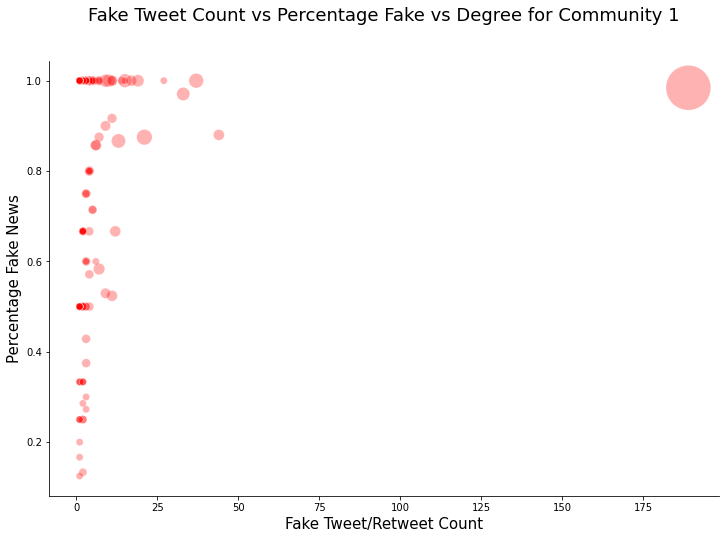

In [61]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=com1_metrics, x="tweet_retweet_fake_count", y="percentage_fake",legend = False, 
                size="degree", sizes=(50, 2000), alpha = 0.3, color = 'r')

plt.xlabel('Fake Tweet/Retweet Count', fontsize=15)
plt.ylabel('Percentage Fake News',  fontsize=15)

ax.set_title('Fake Tweet Count vs Percentage Fake vs Degree for Community 1',fontsize = 18, pad=40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

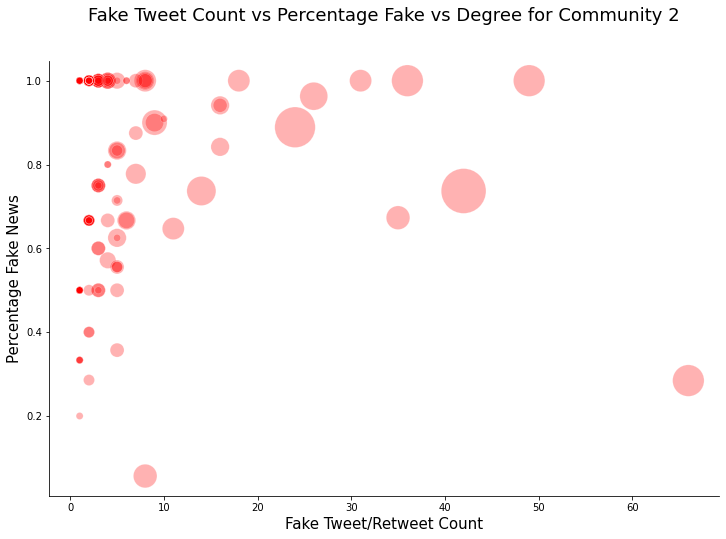

In [62]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=com2_metrics, x="tweet_retweet_fake_count", y="percentage_fake",legend = False, 
                size="degree", sizes=(50, 2000), alpha = 0.3, color = 'r')

plt.xlabel('Fake Tweet/Retweet Count', fontsize=15)
plt.ylabel('Percentage Fake News',  fontsize=15)

ax.set_title('Fake Tweet Count vs Percentage Fake vs Degree for Community 2',fontsize = 18, pad=40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

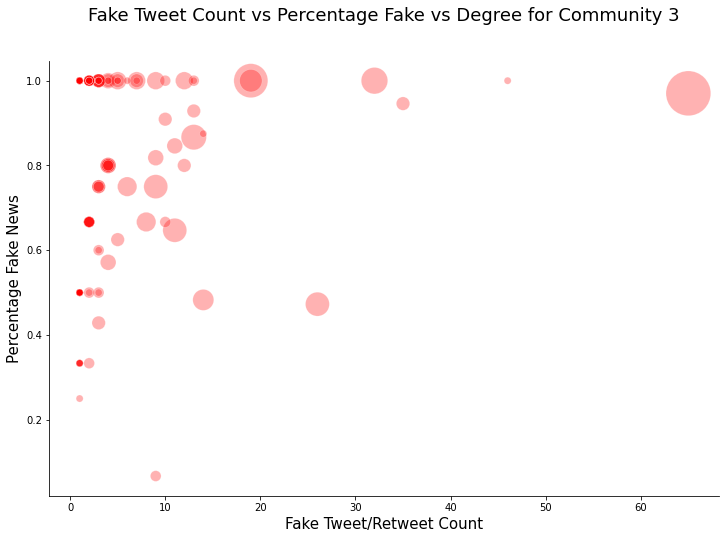

In [63]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=com3_metrics, x="tweet_retweet_fake_count", y="percentage_fake",legend = False, 
                size="degree", sizes=(50, 2000), alpha = 0.3, color = 'r')

plt.xlabel('Fake Tweet/Retweet Count', fontsize=15)
plt.ylabel('Percentage Fake News',  fontsize=15)

ax.set_title('Fake Tweet Count vs Percentage Fake vs Degree for Community 3',fontsize = 18, pad=40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

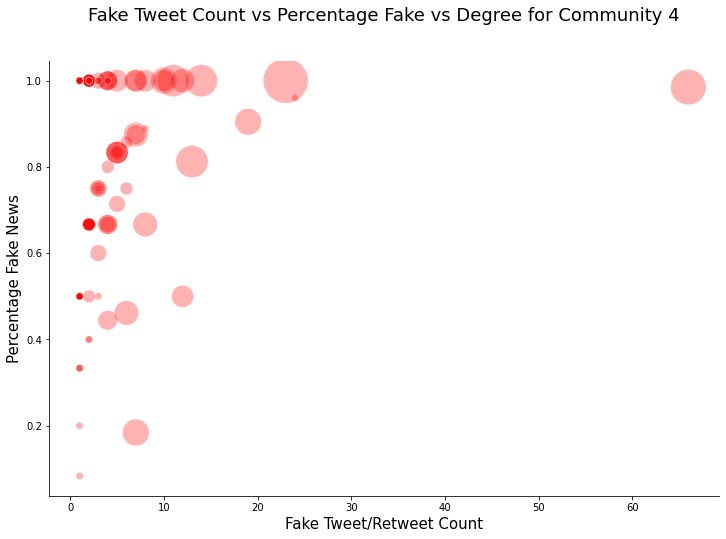

In [64]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=com4_metrics, x="tweet_retweet_fake_count", y="percentage_fake",legend = False, 
                size="degree", sizes=(50, 2000), alpha = 0.3, color = 'r')

plt.xlabel('Fake Tweet/Retweet Count', fontsize=15)
plt.ylabel('Percentage Fake News',  fontsize=15)

ax.set_title('Fake Tweet Count vs Percentage Fake vs Degree for Community 4',fontsize = 18, pad=40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

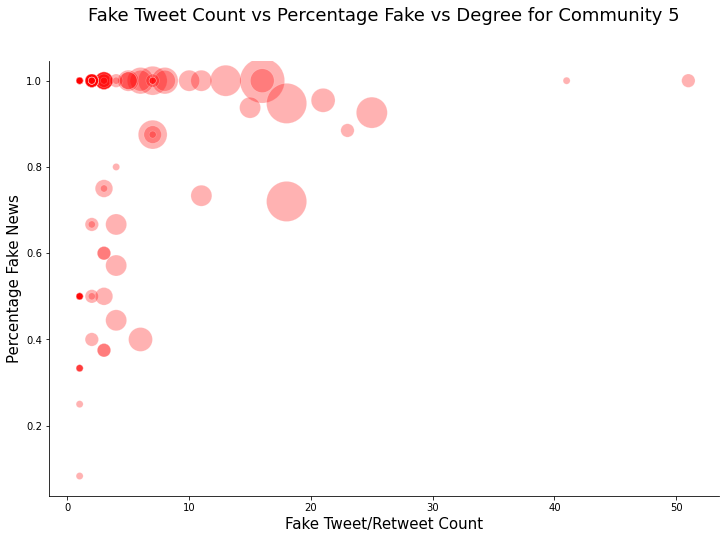

In [77]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=com5_metrics, x="tweet_retweet_fake_count", y="percentage_fake", legend = False,
                size="degree", sizes=(50, 2000), alpha = 0.3, color = 'r', marker='o')

plt.xlabel('Fake Tweet/Retweet Count', fontsize=15)
plt.ylabel('Percentage Fake News',  fontsize=15)

ax.set_title('Fake Tweet Count vs Percentage Fake vs Degree for Community 5',fontsize = 18, pad=40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [78]:
import plotly.express as px

In [104]:
fig = px.scatter(com1_metrics, x="tweet_retweet_fake_count", y="degree", size = 'degree', color="percentage_fake",
                 hover_name="user_id", log_y=False, size_max=60, color_continuous_scale=px.colors.diverging.Temps,
                title="Fake Tweet Count vs Percentage Fake vs Degree for Community 1",
                labels={
                     "tweet_retweet_fake_count": "Fake Tweet/Retweet Count",
                     "degree": "Degree",
                     "percentage_fake": "Percentage Fake"
                 })
fig.layout.plot_bgcolor = 'rgb(255,255,255)'
fig.show()

In [105]:
fig = px.scatter(com2_metrics, x="tweet_retweet_fake_count", y="degree", size = 'degree', color="percentage_fake",
                 hover_name="user_id", log_y=False, size_max=60, color_continuous_scale=px.colors.diverging.Temps,
                title="Fake Tweet Count vs Percentage Fake vs Degree for Community 2",
                labels={
                     "tweet_retweet_fake_count": "Fake Tweet/Retweet Count",
                     "degree": "Degree",
                     "percentage_fake": "Percentage Fake"
                 })
fig.layout.plot_bgcolor = 'rgb(255,255,255)'
fig.show()

In [106]:
fig = px.scatter(com3_metrics, x="tweet_retweet_fake_count", y="degree", size = 'degree', color="percentage_fake",
                 hover_name="user_id", log_y=False, size_max=60, color_continuous_scale=px.colors.diverging.Temps,
                title="Fake Tweet Count vs Percentage Fake vs Degree for Community 3",
                labels={
                     "tweet_retweet_fake_count": "Fake Tweet/Retweet Count",
                     "degree": "Degree",
                     "percentage_fake": "Percentage Fake"
                 })
fig.layout.plot_bgcolor = 'rgb(255,255,255)'
fig.show()

In [107]:
fig = px.scatter(com4_metrics, x="tweet_retweet_fake_count", y="degree", size = 'degree', color="percentage_fake",
                 hover_name="user_id", log_y=False, size_max=60, color_continuous_scale=px.colors.diverging.Temps,
                title="Fake Tweet Count vs Percentage Fake vs Degree for Community 4",
                labels={
                     "tweet_retweet_fake_count": "Fake Tweet/Retweet Count",
                     "degree": "Degree",
                     "percentage_fake": "Percentage Fake"
                 })
fig.layout.plot_bgcolor = 'rgb(255,255,255)'
fig.show()

In [103]:
fig = px.scatter(com5_metrics, x="tweet_retweet_fake_count", y="degree", size = 'degree', color="percentage_fake",
                 hover_name="user_id", log_y=False, size_max=60, color_continuous_scale=px.colors.diverging.Temps,
                title="Fake Tweet Count vs Percentage Fake vs Degree for Community 5",
                labels={
                     "tweet_retweet_fake_count": "Fake Tweet/Retweet Count",
                     "degree": "Degree",
                     "percentage_fake": "Percentage Fake"
                 })
fig.layout.plot_bgcolor = 'rgb(255,255,255)'
fig.layout.xaxis.color = 'rgb(0,0,0)'
fig.show()